# CSII 2023 Exercise 10: MIMO Stability and Performance
References:

## State Feedback for Duckiebot Steering
The dynamics of the Duckiebot are given by a simple unicycle model, which is similar to the Duckiebot model presented in the first lecture. We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the Duckiebot in the plane and $\theta$ is the angle of the Duckiebot with respect to the x-axis. The input of the Duckiebot is given by $(v, \omega)$ where $v$ is the forward velocity and $\omega$ is the angular speed. The difference from the lecture formulation is that we use absolute coordinates in global frame $(x, y, \theta)$ for our states and not relative states to our reference line as shown in the figure $(d,\theta)$.

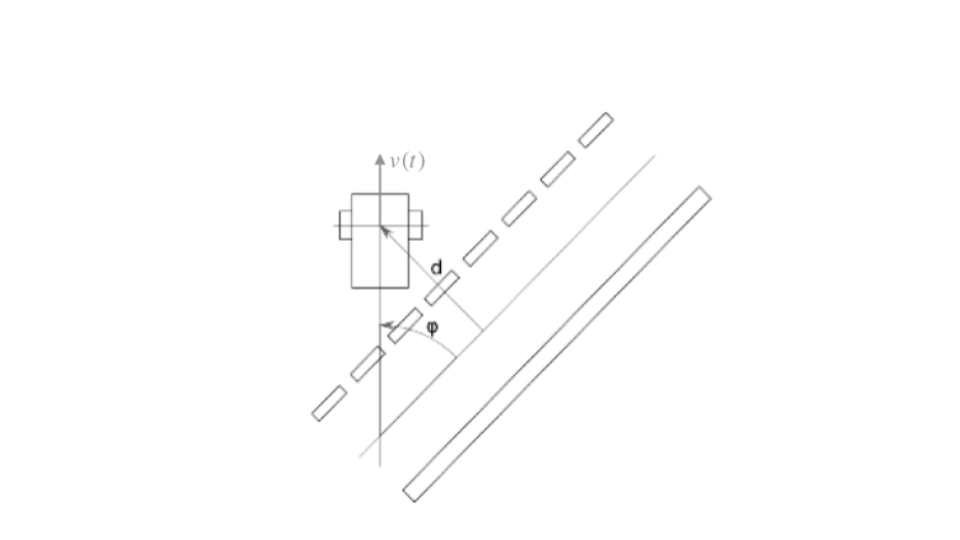

-------

## Installation
We use the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control`, which can be installed using `pip`. If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). The same goes for installing Python packages using `pip`, see this [tutorial](https://packaging.python.org/en/latest/tutorials/installing-packages/). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search.

If you have done all the Jupyter Notebooks leading up to this one, you should have all the necessary libraries installed. 



In [1]:
# Install the required python library with pip
!pip install control


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\nicla\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


-------

## Python Libraries

We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.

In [2]:
# Import the required python libraries
from typing import Optional, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the Duckiebot are defined in the next cell.

In [3]:
# Function: unicycle_update
# Description: Computes the derivative of the state for a unicycle model.
# Input:
#   - t: float, the current time.
#   - x: np.array, the current state vector [x, y, theta].
#   - u: np.array, the input vector [v, w] where v is the forward velocity and w is the angular speed.
#   - params: dict, optional parameters for the unicycle model. It contains the maximum angular speed (max_omega).
# Output:
#   - np.array, the derivative of the state vector [xdot, ydot, thetadot].
# Variables:
#   - max_omega: float, the maximum angular speed allowed for the unicycle.
#   - omega: float, the clipped angular speed based on the maximum angular speed.
# Functionality: The function computes the derivative of the state vector for a unicycle model. It uses the input vector
#                to calculate the forward velocity (v*cos(theta), v*sin(theta)) and the angular speed (w). The angular speed
#                is clipped to the maximum angular speed specified in the parameters. The function returns the derivative
#                of the state vector [xdot, ydot, thetadot].
def unicycle_update(t: float, x: np.array, u: np.array, params: dict) -> np.array:
    max_omega = params.get("max_omega", 0.05)
    omega = np.clip(u[1], -max_omega, max_omega)
    return np.array([
        u[0] * np.cos(x[2]),    # xdot = v*cos(theta)
        u[0] * np.sin(x[2]),    # ydot = v*sin(theta)
        omega                   # thetadot = w
    ])


# Function: unicycle_output
# Description: Computes the output of the unicycle model.
# Input:
#   - t: float, the current time.
#   - x: np.array, the current state vector [x, y, theta].
#   - u: np.array, the input vector [v, w] where v is the forward velocity and w is the angular speed.
#   - params: dict, optional parameters for the unicycle model.
# Output:
#   - np.array, the output vector [x, y].
# Functionality: The function computes the output of the unicycle model. It returns the position vector [x, y] from the
#                state vector [x, y, theta].
def unicycle_output(t: float, x: np.array, u: np.array, params: dict) -> np.array:
    return x[0:2]

## Plotting

The next cell implements some plotting functions using the [Matplotlib](https://matplotlib.org/) library. If you are interested, take a look.

In [4]:
# Function: plot_track
# Description: Plots the trajectory, lateral position, and control input of a reference and controller system.
# Input:
#   - x_coord_ref: np.array, the x-coordinate of the reference trajectory.
#   - y_coord_ref: np.array, the y-coordinate of the reference trajectory.
#   - theta_ref: np.array, the angle of the reference trajectory.
#   - t: np.array, the time vector.
#   - w_curvy: np.array, the angular velocity of the reference trajectory.
#   - y_ctr: Optional[np.array], the lateral position of the controller trajectory (default: None).
#   - w_ctr: Optional[np.array], the angular velocity of the controller trajectory (default: None).
# Output: None
# Variables:
#   - None
# Functionality: This function plots the trajectory, lateral position, and control input of a reference and actual system.
#                The function plots the reference trajectory, and if provided, the
#                acutal trajectory. It also plots the lateral position and control input over time.
def plot_track(x_coord_ref: np.array, y_coord_ref: np.array,
               theta_ref: np.array, t: np.array,
               w_curvy: np.array,
               y_ctr: Optional[np.array] = None,
               w_ctr: Optional[np.array] = None) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout.
    plt.figure(figsize=[9, 4.5])

    # Plot the resulting trajectory (and some road boundaries).
    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(["reference"])

    if y_ctr is not None:
        plt.plot(y_ctr, x_coord_ref, "r", linewidth=1)
        plt.legend(["reference", "controller"])

    else:
        plt.legend(["reference"])

    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, "k-", linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, "k--", linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, "k-", linewidth=1)

    plt.xlabel("y [m]")
    plt.ylabel("x [m]");
    plt.axis("Equal")

    # Plot the lateral position.
    plt.subplot(2, 2, 2)
    plt.plot(t, y_coord_ref)

    if y_ctr is not None:
        plt.plot(t_curvy, y_ctr, "r")
        plt.legend(["reference", "controller"])

    else:
        plt.legend(["reference"])

    plt.ylabel("Lateral position $y$ [m]")

    # Plot the control input.
    plt.subplot(2, 2, 4)
    plt.plot(t, w_curvy)
    if w_ctr is not None:
        plt.plot(t_curvy, w_ctr, "r")
        plt.legend(["reference", "controller"])
        
    else:
        plt.legend(["reference"])

    plt.ylabel("$\\omega$ [rad/s]")
    plt.xlabel("Time t [sec]")
    plt.tight_layout()

## Parameters and Reference Track

We set a default Duckiebot velocity and generate the nonlinear system using the `control` library. 

In [5]:
# Default Duckiebot velocity in m/s.
duckie_params={"velocity": 0.1, "max_omega": 0.05}

# Define the Duckiebot's steering dynamics as an input/output system.
duckiebot = ct.NonlinearIOSystem(
    unicycle_update, unicycle_output, states=3, name="duckiebot",
    inputs=("v", "w"), outputs=("x", "y"), params=duckie_params)

v0 = duckie_params["velocity"]

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the `else` line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angluar velocity `w_curvy`.

In [ ]:
# Control inputs.

curve_difficulty_levels = ["easy", "hard", "straight"]
curve_difficulty = curve_difficulty_levels[2]

T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=="easy":
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)

elif curve_difficulty=="hard":
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)

else:
    # Modify this function to create your own reference track.
    w_curvy = np.zeros(T_curvy.shape)
    
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator.
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    duckiebot, T_curvy, u_curvy, X0_curvy, params=duckie_params, return_x=True)

# FILEPATH: /d:/6CS2Private/control2JN/CS2_2024_unicycle_MIMO_Stability.ipynb
plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)
y_ref = x_curvy[1]
r = np.expand_dims(y_ref, axis=0)
t = T_curvy

## Linearization, Normalization and State Space Represenation

In the next cell we show you how you to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.


In [6]:
# Define the lateral dynamics as a subset of the full Duckiebot steering dynamics.

lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: unicycle_update(
        t, [0., x[0], x[1]], [params.get("velocity", 1), u[0]], params)[1:],
    lambda t, x, u, params: unicycle_output(
        t, [0., x[0], x[1]], [params.get("velocity", 1), u[0]], params)[1:],
    states=2, name="lateral", inputs=("w"), outputs=("y")
)

# Compute the linearization at velocity v0 = 0.1 m/sec.
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=duckie_params)

print("Linearized system dynamics:\n")
print(lateral_linearized)

# Save the system matrices for later use.
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C

Linearized system dynamics:

<LinearIOSystem>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[0.  0.1]
     [0.  0. ]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



------

## Exercise 1:

Derive the MIMO transfer function matrix of the Duckiebot. Write it as a Python Transfer Function object. Assume $v=1$

_Hint: The MIMO transfer function has been derived in a previous exercise. Use numerator and denominator form to write the transfer function with ct.tf(num, den)_

In [ ]:
# Create the MIMO transfer function
num = [[[], []], 
       [[], []]]
den = [[[], []], 
       [[], []]]
mimosys = ct.tf(num, den)

## Solution 1:
Below the MIMO transfer function for the Duckiebot:
$$ P(s) = 
\begin{bmatrix}
\frac{3s}{s+1} & \frac{v}{s^2} \\
s & \frac{1}{s}
\end{bmatrix}
$$

In [15]:
# Creating a MIMO system using controls libraray
num = [[[3, 0], [1]], 
       [[1, 0], [1]]]
den = [[[1, 1], [1, 0, 0]], 
       [[1], [1, 0]]]
mimosys = ct.tf(num, den)
print(mimosys)



Input 1 to output 1:
 3 s
-----
s + 1

Input 1 to output 2:
s
-
1

Input 2 to output 1:
 1
---
s^2

Input 2 to output 2:
1
-
s



------

## Exercise 2a:
Create the 4 transfer functions found in the MIMO transfer function matrix separately and find their poles. 

In [ ]:
tf11 = ct.tf([], [])
tf12 = ct.tf([], [])
tf21 = ct.tf([], [])
tf22 = ct.tf([], [])

print("Poles of tf11: ", ct.pole(tf11))
print("Poles of tf12: ", ct.pole(tf12))
print("Poles of tf21: ", ct.pole(tf21))
print("Poles of tf22: ", ct.pole(tf22))

## Solution 2a:

In [13]:
tf11 = ct.tf([3, 0], [1, 1])
tf12 = ct.tf([1], [1, 0, 0])
tf21 = ct.tf([1, 0], [1])
tf22 = ct.tf([1], [1, 0])

print("Poles of tf11: ", ct.pole(tf11))
print("Poles of tf12: ", ct.pole(tf12))
print("Poles of tf21: ", ct.pole(tf21))
print("Poles of tf22: ", ct.pole(tf22))

Poles of tf11:  [-1.+0.j]
Poles of tf12:  [0.+0.j 0.+0.j]
Poles of tf21:  []
Poles of tf22:  [0.+0.j]


## Exercise 2b: 
Calculate the poles of the MIMO transfer function matrix. What do you notice about the poles? Are they the same magnitude and multiplicity as the ones found in 2a? Is the system stable or unstable?

In [16]:
print("Poles of mimosys: ")

Poles of mimosys:  [-1.+0.j  0.+0.j  0.+0.j]


## Solution 2b:

In [ ]:
print("Poles of mimosys: ", ct.pole(mimosys))

------

## Exercise 3a:

Check if the system can be decoupled. Find the RGA matrix. 

_Hint: You can use 'ct.freqresp(mimosys, omega)' to obtain magnitudes and phases._ 

In [ ]:
def polar_to_complex(magnitude: float, phase_rad: float) -> complex:
    complex_number = magnitude * (np.cos(phase_rad) + 1j * np.sin(phase_rad))
    return complex_number

def MIMORGA2x2(mimosys: ct.TransferFunction, omega: float) -> np.matrix:
    # Calculate MIMO system at the particular frequency. 


    RGA = np.array([[0, 0], [0, 0]])
    
    return RGA

RGA = MIMORGA2x2(mimosys, 1)
print(RGA)

## Solution 3a:

In [71]:
def polar_to_complex(magnitude: float, phase_rad: float) -> complex:
    complex_number = magnitude * (np.cos(phase_rad) + 1j * np.sin(phase_rad))
    return complex_number

def MIMORGA2x2(mimosys: ct.TransferFunction, omega: float) -> np.matrix:
    # Calculate MIMO system at the particular frequency. 
    mag, phase, omega = ct.freqresp(mimosys, omega)
    p11 = polar_to_complex(mag[0][0], phase[0][0])
    p12 = polar_to_complex(mag[0][1], phase[0][1])
    p21 = polar_to_complex(mag[1][0], phase[1][0])
    p22 = polar_to_complex(mag[1][1], phase[1][1])
    
    lm = 1 / (1 - (p12*p21)/(p11*p22))
    abslm = float(abs(lm))
    
    # Fill RGA matrix
    RGA = np.array([[abslm, 1-abslm], [1-abslm, abslm]])
    
    return RGA

RGA = MIMORGA2x2(mimosys, 1)
print(RGA)

[[ 1.34164079 -0.34164079]
 [-0.34164079  1.34164079]]


## Exercise 3b: 
Calculate the RGA number of the MIMO system and determine if it should be decoupled. 

_Hint: A RGA number under 1 should be sufficient for our purposes_

In [ ]:
def RGANum(RGA: np.array) -> float:

    return RGAnumber

RGAnumber = RGANum(RGA)
print(RGAnumber)

## Solution 3b:

In [69]:
def RGANum(RGA: np.array) -> float:
    dimensions = RGA.shape[0]
    # Prepare identity matrix
    I = np.eye(dimensions)

    # Calculate RGA Number
    RGAnumber = np.linalg.norm(RGA - I)
    return RGAnumber

RGAnumber = RGANum(RGA)
print(RGAnumber)

0.6832815729997477


## Exercise 3c:
Write a quick script to check the RGA number at different frequencies $\omega$. Then plot these against $\omega$. What is a suitable range for $\omega$?

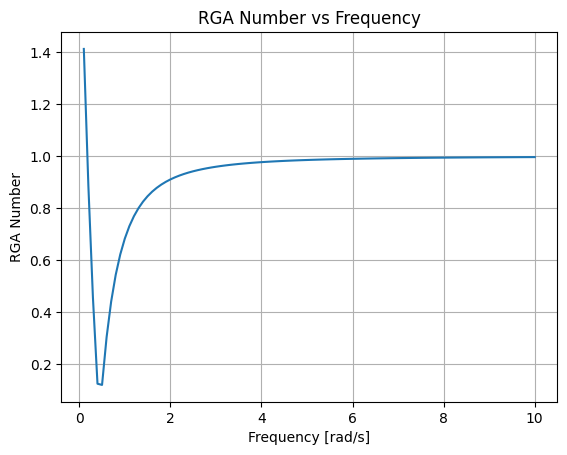

array([1.41165159, 0.88582797, 0.45651273, 0.12591486, 0.12132034,
       0.30466384, 0.44120041, 0.54399491, 0.62247183, 0.68328157,
       0.73109943, 0.76923077, 0.80003682, 0.82522573, 0.84604989,
       0.86343993, 0.8780965 , 0.89055373, 0.90122361, 0.9104275 ,
       0.91841864, 0.92539857, 0.93152909, 0.93694126, 0.94174203,
       0.94601934, 0.94984601, 0.95328273, 0.95638035, 0.95918177,
       0.96172336, 0.9640361 , 0.96614651, 0.96807741, 0.96984848,
       0.97147682, 0.97297729, 0.97436289, 0.97564499, 0.97683363,
       0.97793763, 0.97896482, 0.97992214, 0.98081576, 0.9816512 ,
       0.98243339, 0.98316674, 0.98385523, 0.98450243, 0.98511157,
       0.98568558, 0.98622709, 0.98673851, 0.98722202, 0.98767962,
       0.98811312, 0.98852417, 0.98891431, 0.98928491, 0.98963727,
       0.98997256, 0.99029187, 0.99059618, 0.99088642, 0.99116346,
       0.99142806, 0.99168098, 0.99192288, 0.99215439, 0.9923761 ,
       0.99258856, 0.99279226, 0.9929877 , 0.99317529, 0.99335

In [73]:
def RGAPlot(mimosys: ct.TransferFunction, omega: np.array) -> np.array:           
    plt.figure()
    plt.plot(omega, RGAnumber)
    plt.xlabel("Frequency [rad/s]")
    plt.ylabel("RGA Number")
    plt.title("RGA Number vs Frequency")
    plt.grid(True)
    plt.show()

    return RGAnumber

RGAPlot(mimosys, np.linspace(0.1, 10, 100))

## Solution 3c:

Below a possible implementation:

In [ ]:
def RGAPlot(mimosys: ct.TransferFunction, omega: np.array) -> np.array:
    RGAnumber = np.zeros_like(omega)
        
    for i, w in enumerate(omega):
        RGA = MIMORGA2x2(mimosys, w)
        RGAnumber[i] = RGANum(RGA)
            
    plt.figure()
    plt.plot(omega, RGAnumber)
    plt.xlabel("Frequency [rad/s]")
    plt.ylabel("RGA Number")
    plt.title("RGA Number vs Frequency")
    plt.grid(True)
    plt.show()

    return RGAnumber

RGAPlot(mimosys, np.linspace(0.1, 10, 100))

------

## Exercise 4:
We note that for low frequencies, the system can be decoupled. Nice! Since the Duckiebot is driving on the road at a relatively low speed $v=1$, we can assume all disturbances and references are of low frequencies as well. 

We now will try to build two PI controllers. Below is a reference controller. Test it and see if you can improve it. 

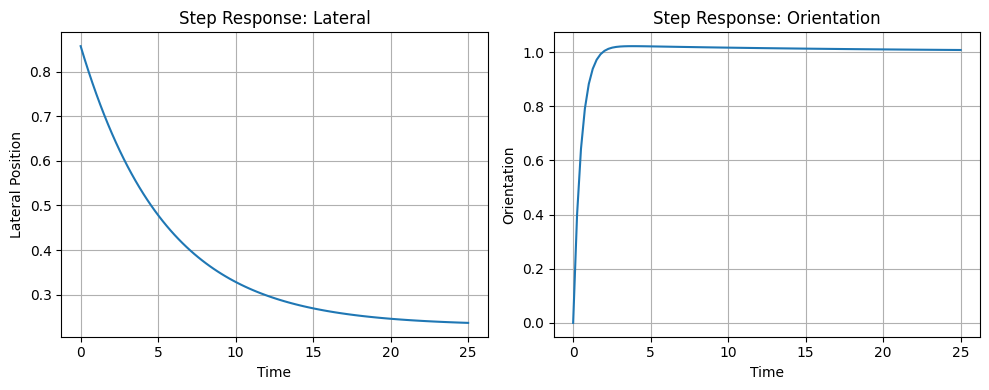

In [94]:
def buildMIMOcontroller(kp: np.array, ki: np.array) -> ct.TransferFunction:
    num = [[[kp[0], ki[0]], [0]], 
       [[0], [kp[1], ki[1]]]]
    den = [[[1, 0], [1]], 
        [[1], [1, 0]]]

    mimocont = ct.tf(num, den)

    return mimocont

def testMIMOcontroller(mimocont: ct.TransferFunction, mimosys: ct.TransferFunction) -> None:
    mimo_openloop = mimocont * mimosys
    
    lateralTF = ct.feedback(mimo_openloop[0, 0])
    orientationTF = ct.feedback(mimo_openloop[1, 1])

    t0, y0 = ct.step_response(lateralTF)
    t1, y1 = ct.step_response(orientationTF)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the step response for lateralTF
    axs[0].plot(t0, y0)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Lateral Position')
    axs[0].set_title('Step Response: Lateral')
    axs[0].grid(True)

    # Plot the step response for orientationTF
    axs[1].plot(t1, y1)
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Orientation')
    axs[1].set_title('Step Response: Orientation')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

kp = np.array([1, 1])
ki = np.array([0.1, 0.1])
mimocont = buildMIMOcontroller(kp, ki)

testMIMOcontroller(mimocont, mimosys)